instalar previamente ARCH

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import datetime as dt
import arch.data.sp500
import pandas as pd
import numpy as np
import warnings

pd.set_option('max_colwidth',100)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

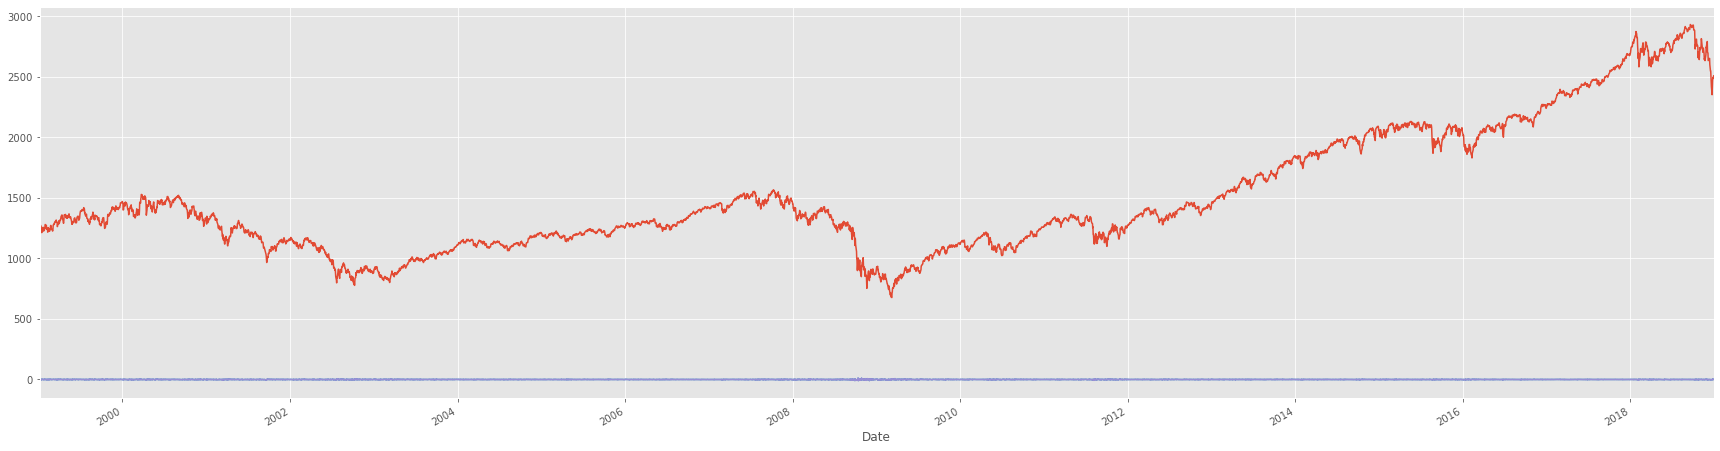

In [2]:
st = dt.datetime(1988, 1, 1)
en = dt.datetime(2018, 1, 1)
data = arch.data.sp500.load() #decarga de datos, precio de cierre de S&P500
market = data["Adj Close"]
market.plot(figsize=(30,8))

#caluclo de returnos (pt-pt-1)p_t
returns = 100 * market.pct_change().dropna() # ut : returns
# cambio de nombre
#nota se pierde el primer dato
returns_df = pd.DataFrame(returns).rename(columns={'Adj Close':'returns'})

#ploteo
ax = returns.plot(figsize=(30,8))
xlim = ax.set_xlim(returns.index.min(), returns.index.max())
returns.plot(figsize=(30,8));

<AxesSubplot:xlabel='Date'>

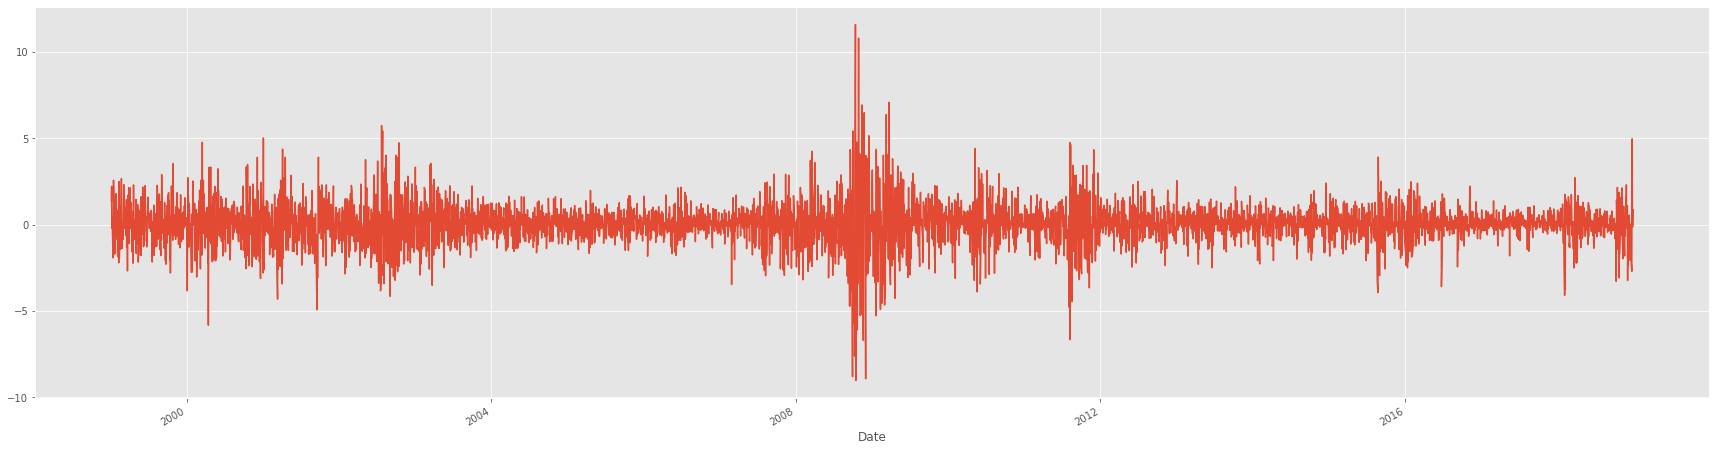

In [3]:
#grafica de los retornos, ()incremento porcentual
returns.plot(figsize=(30,8))

En esta serie podemos observar que los periodos de alta volatilidad tienen una tendencia a agruparse

In [4]:
from arch import arch_model

#primera entrada, data, segunda entarda modelo, demás entradas parametros 
# la "o" implica el orden "creo"
arch_model_fited = arch_model(returns, vol = "Garch", p = 1, o = 0, q = 1).fit()
print(arch_model_fited.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 278392203378920.22
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2801628462.676755
Iteration:      3,   Func. Count:     22,   Neg. LLF: 10200.264821310848
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7030.288339344431
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7051.517858694138
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6938.100841509388
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6936.741981139894
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6936.718529877007
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6936.718476988985
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations:

Observando el ajuste podemos observar que el modelo es significativos y los intervalos no tocan el cero y de aquí podemos deducir que las campanas gausianas que modelan la serie sí dependen autoregresivamente.

y la volatilidad tambien depende de la volatilidad anterior (beta) y tenemos que corroborar que la alpha y beta no sumen más de uno porque sino tendríamos una varianza negativa

In [5]:
# corroboración de la varianza
0.0175/(1-(0.1022+0.8852))

1.3888888888888828

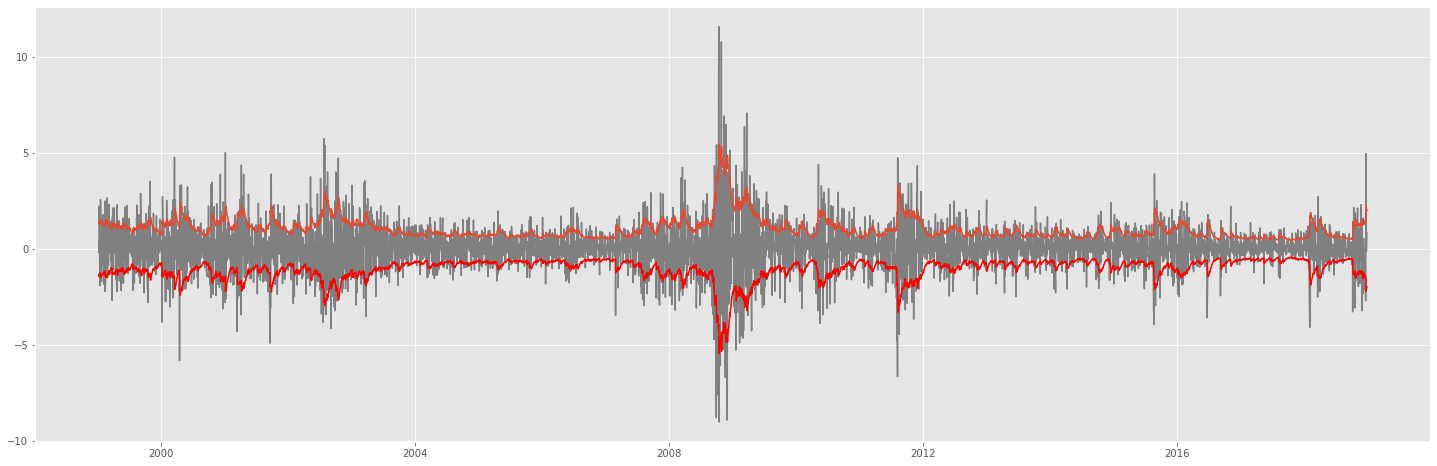

In [6]:
fig, ax = plt.subplots(figsize=(25, 8))

#retornos
ax.plot(returns, label='retornos', color = 'gray')
#banda superior
ax.plot(arch_model_fited.conditional_volatility,  label='volatilidad')
#banda inferior se multiplica por menos uno
ax.plot(-1*arch_model_fited.conditional_volatility,  label='volatilidad', color = 'red')

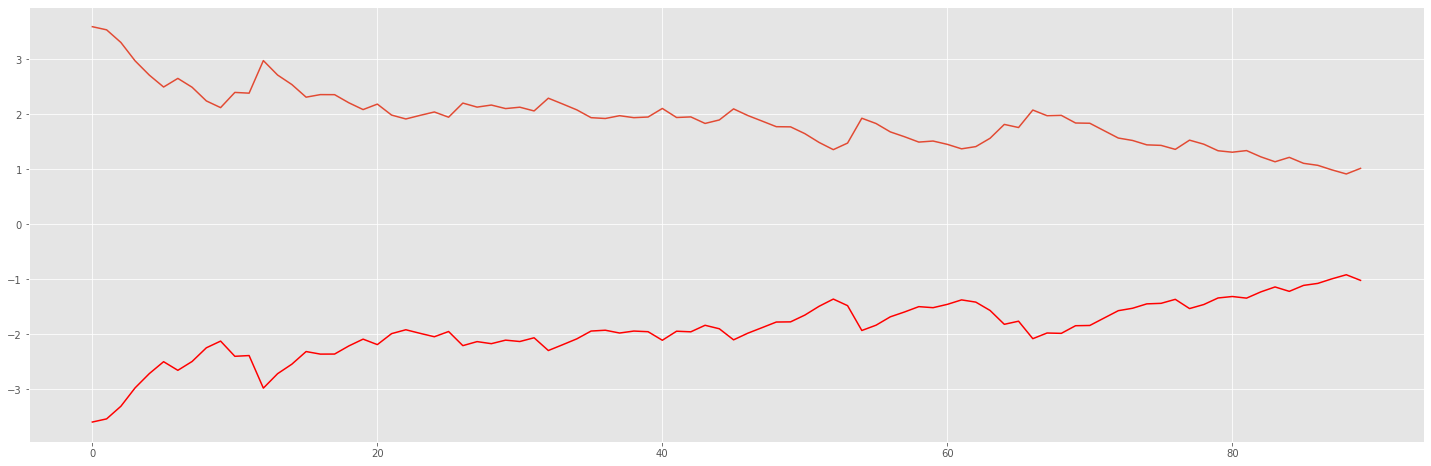

In [7]:
#forecast del modelo
forecasts = arch_model_fited.forecast(start=dt.datetime(2018, 12, 31), #ultima fecha observada
                                      horizon=30*3,  #tres meses al futuro
                                      method="bootstrap", #vía bootstrap
                                      simulations=5) # 5 simulaciones
# me quedo con la simulaciones
simulations = forecasts.simulations
fig, ax = plt.subplots(figsize=(25, 8))
#grafica de la varianza estimada
#varianza por arriba
line = ax.plot(forecasts.variance.iloc[-1].values)
line[0].set_label("Expected variance")
#varianza por debajo
line_2 = ax.plot(-1 * forecasts.variance.iloc[-1].values, color = 'red')
line_2[0].set_label("Expected variance")

Lo anterior se usa para modelado de portafolios de inversion y acciones, y lo que se tiene calcualdo es una especie de valor en riesgo, para este tipo de ejercicios lo que nos interesa es que no supere cierto umbral